In [1]:
import json
import tarfile
import os.path
import random 
import time
from os import path
from PIL import Image, ImageOps
import imageio
from imageio import imread


In [2]:
!pip install torchmetrics
!pip install wandb
!pip install  segmentation_models_pytorch

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import tqdm
import torch.optim as optim

import torchmetrics
from torchsummary import summary 

### **Data** Preprocessing

In [4]:
# extracting the data
tf = tarfile.open("/content/idd-lite.tar.gz")
tf.extractall("/content/idd_extracted")
tf.close()


In [5]:
path = "/content/idd_extracted/idd20k_lite"

print("Folders :\t\t ", os.listdir(path))
print("gtFine :\t\t ", os.listdir(os.path.join(path, "gtFine")))
print("leftImg8bit :\t\t ", os.listdir(os.path.join(path, "leftImg8bit")))
print("\ngtFine train:\t\t ", os.listdir(os.path.join(path, "gtFine/train")))  #total scenes
print("\nleftImg8bit train:\t\t ", os.listdir(os.path.join(path, "leftImg8bit/train")))

Folders :		  ['leftImg8bit', 'gtFine']
gtFine :		  ['val', 'train']
leftImg8bit :		  ['val', 'test', 'train']

gtFine train:		  ['475', '483', '517', '76', '350', '482', '145', '0', '37', '540', '336', '428', '38', '375', '128', '45', '462', '367', '422', '452', '298', '578', '90', '338', '2', '154', '231', '260', '84', '177', '402', '30', '530', '57', '86', '301', '127', '543', '371', '175', '439', '325', '152', '247', '361', '266', '308', '468', '64', '23', '223', '104', '224', '532', '68', '65', '11', '5', '143', '489', '520', '220', '414', '250', '124', '448', '299', '317', '69', '460', '373', '512', '144', '406', '136', '503', '110', '320', '541', '163', '16', '25', '285', '59', '380', '433', '370', '303', '170', '269', '26', '131', '261', '554', '490', '98', '78', '56', '321', '457', '493', '382', '288', '315', '411', '277', '204', '293', '125', '94', '36', '209', '283', '40', '174', '173', '302', '519', '225', '473', '376', '347', '101', '563', '268', '498', '322', '248', '39', 

In [6]:
print("leftImg8bit train - 0 : ", os.listdir(os.path.join(path, "leftImg8bit/train/0"))) # frames

print("\n\ngtFine train - 0 : ", os.listdir(os.path.join(path, "gtFine/train/0")))

leftImg8bit train - 0 :  ['024541_image.jpg', '024703_image.jpg']


gtFine train - 0 :  ['024541_label.png', '024541_inst_label.png', '024703_inst_label.png', '024703_label.png']


In [7]:

#train dataframe
img_lst, mask_lst = [], []
for img_scene in os.listdir(os.path.join(path, "leftImg8bit/train")):
    imgscene_path = os.path.join(path, f"leftImg8bit/train/{img_scene}")
    maskscene_path = os.path.join(path, f"gtFine/train/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        frame = frame[:-9] + 'label.png'
        maskframe_path = os.path.join(maskscene_path, frame)
        img_lst.append(imgframe_path)
        mask_lst.append(maskframe_path)

data = pd.DataFrame(list(zip(img_lst, mask_lst)), columns = ['images', 'mask'])
data['images'] = sorted(data['images'])
data['mask'] = sorted(data['mask'])

data.head(3)

,images,mask
0,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/trai...
1,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/trai...
2,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/trai...


In [8]:
#val dataframe
val_img, val_mask = [], []
for img_scene in os.listdir(os.path.join(path, "leftImg8bit/val")):
    imgscene_path = os.path.join(path, f"leftImg8bit/val/{img_scene}")
    maskscene_path = os.path.join(path, f"gtFine/val/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        frame = frame[:-9] + 'label.png'
        maskframe_path = os.path.join(maskscene_path, frame)
        val_img.append(imgframe_path)
        val_mask.append(maskframe_path)

valdata = pd.DataFrame(list(zip(val_img, val_mask)), columns = ['images', 'mask'])
valdata['images'] = sorted(valdata['images'])
valdata['mask'] = sorted(valdata['mask'])

valdata.head(3)

,images,mask
0,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/val/...
1,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/val/...
2,/content/idd_extracted/idd20k_lite/leftImg8bit...,/content/idd_extracted/idd20k_lite/gtFine/val/...


In [9]:
#test dataframe
test_path = "/content/idd_extracted/idd20k_lite/leftImg8bit/test"
test_imgs = []
for img_scene in os.listdir(test_path):
    imgscene_path = os.path.join(path, f"leftImg8bit/test/{img_scene}")
    for frame in os.listdir(imgscene_path):
        imgframe_path = os.path.join(imgscene_path, frame)
        test_imgs.append(imgframe_path)
test_data = pd.DataFrame(test_imgs, columns = ['images'])    

test_data.head(3)

,images
0,/content/idd_extracted/idd20k_lite/leftImg8bit...
1,/content/idd_extracted/idd20k_lite/leftImg8bit...
2,/content/idd_extracted/idd20k_lite/leftImg8bit...


In [10]:
#unique values in mask
import matplotlib.image as img
u=[]
for ele in data['mask']:
    img = Image.open(ele)
    testImage = np.array(img)
    u+=list((np.unique(testImage)))

print(set(u))


{0, 1, 2, 3, 4, 5, 6, 255}


In [11]:
classes = ['Sky', 'Building','Road','Tree', 'SignSymbol', 'Car', 'Pedestrian', 'unknown']

In [12]:
def display_img_mask(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30, on_val=True):
  # Assigning some RGB colors for the 7 + 1 (Misc) classes
  colors = np.array([(128, 64, 128), (244, 35, 232), (220, 20, 60), (0, 0, 230), (220, 190, 40), (70, 70, 70), (70, 130, 180), (0, 0, 0)], dtype=np.int64)
  assert isinstance(list_images, list)
  assert len(list_images) > 0
  assert isinstance(list_images[0], np.ndarray)
  
  if list_titles is not None:
    assert isinstance(list_titles, list)
    assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))
  
  num_images  = len(list_images)
  num_cols    = min(num_images, num_cols)
  num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

  fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)

  # Create list of axes for easy iteration.
  if isinstance(axes, np.ndarray):
    list_axes = list(axes.flat)
  else:
    list_axes = [axes]

  for i in range(num_images):
    label_map = imageio.core.util.Array(np.asarray(list_images[1].squeeze()))
    label_color_image = np.zeros((label_map.shape[0], label_map.shape[1], 3), dtype=np.int64)
    for i in range(7):
      label_color_image[label_map == i] = colors[i]
    label_color_image[label_map == 255] = colors[7]

    img_list = [list_images[0], label_color_image]

    if on_val:
      #if list_images[2] is not None:
        predicted_map = imageio.core.util.Array(np.asarray(list_images[2].squeeze()))
        predicted_color_image = np.zeros((predicted_map.shape[0], predicted_map.shape[1], 3), dtype=np.int64)
        for i in range(7):
          predicted_color_image[predicted_map == i] = colors[i]
        predicted_color_image[predicted_map == 255] = colors[7]
        img_list.append(predicted_color_image)
 
  for i in range(num_images):
    img = img_list[i]
    title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
    list_axes[i].imshow(img)
    list_axes[i].set_title(title, fontsize=title_fontsize) 
    list_axes[i].grid(grid)

  for i in range(num_images, len(list_axes)):
    list_axes[i].set_visible(False)

  fig.tight_layout()
  _ = plt.show()


In [13]:
class IDDdataset(Dataset):
  def __init__(self, data: pd.DataFrame = None, phase='train',transform=None):
    self.data = data
    self.transform = transform
    self.phase=phase
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    if self.phase == 'train':
        img_path = self.data['images'][index]
        mask_path = self.data['mask'][index]
        img = np.array(Image.open(img_path).convert('RGB'))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        if self.transform is not None:
            img = self.transform(img)
            mask =np.resize(mask,(1,224,320))
            mask = torch.tensor(mask)

        return img, mask

    if self.phase=='test':
      img_path = self.data['images'][index]
      img = np.array(Image.open(img_path).convert('RGB'))
      if self.transform:
        img = self.transform(img)
      return img
       
    

In [14]:
trans = transforms.Compose([
  #transforms.ToPILImage(),                          
  transforms.ToTensor(),
  transforms.Resize([224,320]),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = IDDdataset(data, transform = trans)
val_set = IDDdataset(valdata, transform = trans)
test_set = IDDdataset(test_data,  phase='test', transform = trans)

image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 24

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'test': DataLoader(test_set, batch_size=1, shuffle=True, num_workers=0)
}

# Modelling

In [15]:
def mIOU( pred, label, num_classes=7):
    pred = F.softmax(pred, dim=1)              
    pred = torch.argmax(pred, dim=1).squeeze(1)
    iou_list = list()
    present_iou_list = list()

    pred = pred.view(-1)
    label = label.view(-1)
    for sem_class in range(num_classes):
        pred_inds = (pred == sem_class)
        target_inds = (label == sem_class)
        if target_inds.long().sum().item() == 0:
            iou_now = float('nan')
        else: 
            intersection_now = (pred_inds[target_inds]).long().sum().item()
            union_now = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    return np.mean(present_iou_list)

In [16]:
import segmentation_models_pytorch as smp
device = "cuda" if torch.cuda.is_available() else "cpu"
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
    activation="softmax" 
).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [17]:
class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=None, ignore_index=255, reduction='mean'):
        super(CrossEntropyLoss2d, self).__init__()
        self.CE =  nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index, reduction=reduction)

    def forward(self, output, target):
        loss = self.CE(output, target)
        return loss

# optimizer
lr = 1e-4
criterion = CrossEntropyLoss2d()
optimizer = optim.Adam(model.parameters(), lr=lr)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

In [18]:
n_epochs = 40
bs = 24
lr= 5e-4

checkpoint_path = "checkpoint.pth"

In [19]:
import wandb
wandb.login()

config = dict(
    epochs=n_epochs,
    classes=7,
    batch_size=bs,
    learning_rate=lr,
    dataset="IDDlite",
    architecture="Unet")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
def make(config):
    train_loader_, test_loader_ = dataloaders['train'], dataloaders['test']
    model_ = model
    criterion_ = criterion
    optimizer_ = optimizer
    return model_, train_loader_, test_loader_, criterion_, optimizer

def train_log(loss, dicescore, iou, example_ct, epoch):
    wandb.log({"epoch": epoch, "loss": loss, "dicescore": dicescore,  "iou":iou},step=example_ct,commit=False)
    print(f"epoch : {epoch}, LOSS: {loss:.3f}, DICESCORE: {dicescore:.3f}, IOU: {iou:.3f}") 

def val_log(loss, dicescore, iou, example_ct, epoch):
    wandb.log({"epoch": epoch, "val_loss": loss, "val_dicescore": dicescore,  "val_iou":iou},step=example_ct)
    print(f"epoch : {epoch}, VAL_LOSS: {loss:.3f}, VAL_DICESCORE: {dicescore:.3f}, VAL_IOU: {iou:.3f}") 

def tot_log(metrics):
    wandb.log({"epoch": metrics['train'][0], "loss": metrics['train'][1], "dicescore": metrics['train'][2],  "iou":metrics['train'][3],
              "val_epoch": metrics['val'][0], "val_loss": metrics['val'][1], "val_dicescore": metrics['val'][2],  "val_iou":metrics['val'][3]},step=metrics['train'][4])
    
    print(f"epoch : {metrics['train'][0]}, LOSS: {metrics['train'][1]:.3f}, DICESCORE: {metrics['train'][2]:.3f}, IOU: {metrics['train'][3]:.3f},'step':{metrics['train'][4]}") 
    print(f"val_epoch : {metrics['val'][0]}, VAL_LOSS: { metrics['val'][1]:.3f}, VAL_DICESCORE: {metrics['val'][2]:.3f}, VAL_IOU: {metrics['val']:.3f},'val_step':{metrics['val'][4]}") 

In [21]:
from collections import defaultdict
import torch.nn.functional as F


def train_model(model,criterion, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10
    example_ct = 0 
    wandb.watch(model, criterion, log="all", log_freq=10)
    
    
    for epoch in range(n_epochs):
        print('-' * 10)
        print('Epoch : {}/{}'.format(epoch+1, n_epochs))
        
        t = time.time()
        batch_ct, epoch_samples = 0, 0
        log_metrics= {'train':{'dice':0,'loss':0,'iou':0},'val':{'dice':0,'loss':0,'iou':0}}
        
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 

                for inputs, labels in dataloaders[phase]:
                    example_ct +=  len(inputs)
                    batch_ct += 1
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        #print(phase)
                        log_metrics['train']['dice'] += torchmetrics.functional.dice_score(outputs, labels.long().squeeze(1)).cpu().detach().numpy()/len(dataloaders['train']) #metric
                        #print(outputs.size(), labels.long().size())
                        #iou = torchmetrics.functional.jaccard_index(outputs, labels.long(),num_classes=7, ignore_index=255)
                        log_metrics['train']['iou'] += mIOU(outputs, labels.long())/len(dataloaders['train'])
                        loss = criterion(outputs, labels.long().squeeze(1))
                        log_metrics['train']['loss'] +=loss.cpu().detach().numpy()/len(dataloaders['train'])
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step() 
  

            elif phase == 'val':
                model.eval() 
                with torch.no_grad():
                     for inputs, labels in dataloaders[phase]:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        #print(phase)
                        log_metrics['val']['dice'] += torchmetrics.functional.dice_score(outputs, labels.long().squeeze(1)).cpu().detach().numpy()/len(dataloaders['val']) #metric
                        #print(outputs.size(), labels.long().size())
                        #iou = torchmetrics.functional.jaccard_index(outputs, labels.long(),num_classes=7, ignore_index=255)
                        log_metrics['val']['iou'] += mIOU(outputs, labels.long())/len(dataloaders['val'])
                        log_metrics['val']['loss'] += criterion(outputs, labels.long().squeeze(1)).cpu().detach().numpy()/len(dataloaders['val'])
                        #print([epoch,vloss, vdicescore, viou, example_ct])
                        


            
            #print(phase+':')
            #print("\tloss ----", loss.cpu().detach().numpy())
            #print("\n\tdicescore ----",dicescore.cpu().detach().numpy())
            #print("\n\tJaccardscore ----",iou)
            #epoch_loss = loss / epoch_samples

            if phase == 'train':
              scheduler.step()
              #for param_group in optimizer.param_groups:
                  #print("LR is set to", param_group['lr'])

            
            
        #print(log_metrics)
        print('\n')
        print(f"Loss: {log_metrics['train']['loss']:.3f}, Dicescore: {log_metrics['train']['dice']:.3f}, IOU: {log_metrics['train']['iou']:.3f}")
        print(f"Val_loss: {log_metrics['val']['loss']:.3f}, val_dicescore: {log_metrics['val']['dice']:.3f}, Val_IOU: {log_metrics['val']['iou']:.3f}")
        wandb.log(log_metrics)

        # save the model weights
        epoch_loss=log_metrics['val']['loss']
        if  epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)
        
        time_elapsed = time.time() - t
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [22]:
def test_model(model, test_loader, viz=False):
  model.eval()
  test_loss = 0
  test_error = 0
  with torch.no_grad():
    for test_img in test_loader:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      test_img = test_img.to(device) 
      output = model(test_img)
      test_img = test_img.squeeze().cpu().detach().numpy()
      test_img = test_img.swapaxes(0, 1)
      test_img = test_img.swapaxes(1, 2)
      
      store_output = output.squeeze().cpu().detach().numpy()
      output = torch.argmax(output,dim=1).squeeze().cpu().detach().numpy()
      if viz==True:
        display_img_mask(list_images=[test_img,output], 
                list_titles=['test_img', 'output'],
                num_cols=2,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20,
                on_val=False)
        break

##Training

In [ ]:
#model

In [23]:
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  128582 KB |  128582 KB |  128582 KB |       0 B  |\n|       from large pool |  108928 KB |  108928 KB |  108928 KB |       0 B  |\n|       from small pool |   19654 KB |   19654 KB |   19654 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  128582 KB |  128582 KB |  128582 KB |       0 B  |\n|       from large pool |  108928 KB |  108928 KB |

In [24]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warnings.warn("deprecated", DeprecationWarning)

In [26]:
def model_pipeline(hyperparameters):
    with wandb.init(project="IDD_seg", entity="nikilr", config=hyperparameters):
      config = wandb.config
      model, train_loader, test_loader, criterion, optimizer = make(config)
      train_model(model, criterion, optimizer, exp_lr_scheduler)
      test_model(model, test_loader, viz=True)
    return model

wandb: Currently logged in as: nikilr. Use `wandb login --relogin` to force relogin


----------
Epoch : 1/35


/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)




Loss: 1.711, Dicescore: 0.348, IOU: 0.303
Val_loss: 1.619, val_dicescore: 0.506, Val_IOU: 0.442
saving best model to checkpoint.pth
0m 56s
----------
Epoch : 2/35


Loss: 1.548, Dicescore: 0.568, IOU: 0.513
Val_loss: 1.496, val_dicescore: 0.570, Val_IOU: 0.520
saving best model to checkpoint.pth
0m 54s
----------
Epoch : 3/35


Loss: 1.440, Dicescore: 0.614, IOU: 0.568
Val_loss: 1.423, val_dicescore: 0.582, Val_IOU: 0.541
saving best model to checkpoint.pth
0m 55s
----------
Epoch : 4/35


Loss: 1.374, Dicescore: 0.645, IOU: 0.601
Val_loss: 1.373, val_dicescore: 0.615, Val_IOU: 0.570
saving best model to checkpoint.pth
0m 55s
----------
Epoch : 5/35


Loss: 1.334, Dicescore: 0.661, IOU: 0.619
Val_loss: 1.349, val_dicescore: 0.620, Val_IOU: 0.577
saving best model to checkpoint.pth
0m 55s
----------
Epoch : 6/35


Loss: 1.309, Dicescore: 0.676, IOU: 0.635
Val_loss: 1.335, val_dicescore: 0.625, Val_IOU: 0.581
saving best model to checkpoint.pth
0m 54s
----------
Epoch : 7/35


Loss: 1.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


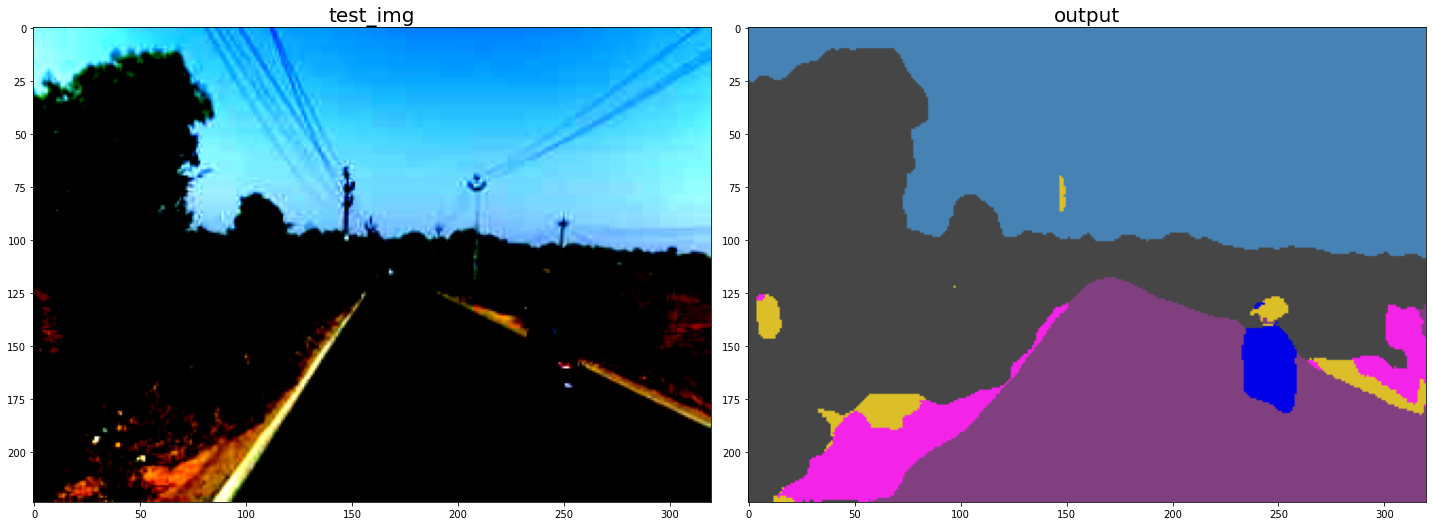

In [27]:
model = model_pipeline(config)

###Inference

In [ ]:
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name='resnet50',
    encoder_weights='imagenet',
    in_channels=3,
    classes=7,
    #activation="softmax"  ## An activation function to apply after the final convolution layer
).to(device)

model_ = model
state_dict = torch.load("/content/checkpoint.pth")
model_.load_state_dict(state_dict)
model_.eval()

In [36]:
def compare_val(model, valdata: pd.DataFrame,idx=1, phase='test', transform=trans, test_bs=1, device=device):
  valpath = [valdata['images'][idx]]
  val_img = pd.DataFrame(data=valpath, columns=['images'])
  val_dataset = IDDdataset(val_img, phase=phase, transform=trans)
  val_loader = DataLoader(val_dataset, test_bs, shuffle=False)
  

  with torch.no_grad():
    for val_img in val_loader:
      val_img = val_img.to(device) 
      predicted = torch.argmax(model(val_img),dim=1).squeeze().cpu().detach().numpy()

      def get_val_mask(val_img):
        img = val_img.squeeze().cpu().detach().numpy()
        val_mask = np.asarray(Image.open(valdata['mask'][idx]))
        val_img = val_img.cpu().squeeze().numpy()
        val_img = val_img.swapaxes(0, 1)
        val_img = val_img.swapaxes(1, 2)
        return val_img, val_mask
      
      val_img, val_mask = get_val_mask(val_img)
      #display_img_mask(val_img, val_mask, predicted)
      display_img_mask(list_images=[val_img, val_mask, predicted], 
                list_titles=['val_img', 'val_mask', 'predicted'],
                num_cols=3,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


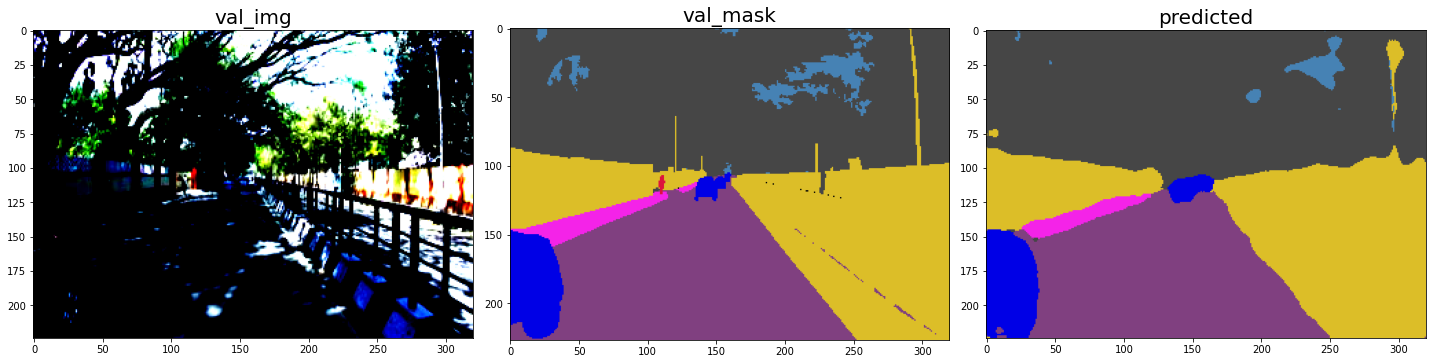

In [63]:
compare_val(model_, valdata, idx=200)

In [55]:
def test_model(model, test_loader, viz=False):
  model.eval()
  test_loss = 0
  test_error = 0
  with torch.no_grad():
    for test_img in test_loader:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      test_img = test_img.to(device) 
      output = model(test_img)
      test_img = test_img.squeeze().cpu().detach().numpy()
      test_img = test_img.swapaxes(0, 1)
      test_img = test_img.swapaxes(1, 2)
      
      store_output = output.squeeze().cpu().detach().numpy()
      output = torch.argmax(output,dim=1).squeeze().cpu().detach().numpy()
      if viz==True:
        display_img_mask(list_images=[test_img,output], 
                list_titles=['test_img', 'output'],
                num_cols=2,
                figsize=(20, 10),
                grid=False,
                title_fontsize=20,
                on_val=False)
        break
  
#test_model(model, test_loader, viz=True)

In [53]:
test_bs = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


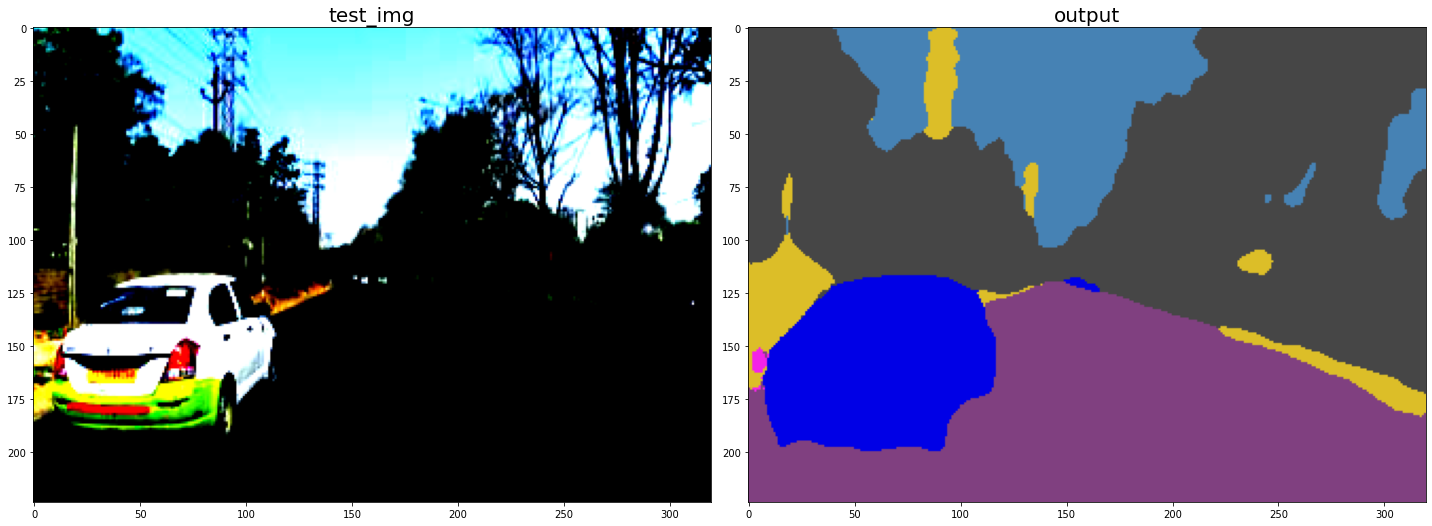

In [57]:
test_loader=dataloaders['test']
test_model(model, test_loader, viz=True)